# Initialize Environment

In [1]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# Load Data from Separate Notebook

In [2]:
bonds   = ['EDV', 'BIV', 'VGIT', 'BLV', 'VGLT', 'VMBS', 'BSV', 'VTIP', 'VGSH', 'BND', 'VCIT', 'VCLT', 'VCSH', 'VTC', 'VTEB']
intl    = ['VT', 'VSGX', 'VEU', 'VSS', 'VEA', 'VGK', 'VPL', 'VNQI', 'VIGI', 'VYMI', 'VXUS', 'VWO']
sectors = ['VOX', 'VCR', 'VDC', 'VDE', 'VFH', 'VHT', 'VIS', 'VGT', 'VAW', 'VNQ', 'VPU']
tickers = sectors #+ bonds
tickers = ['VTI', 'VUG', 'VOT', 'VBK', 'VYM', 'VYMI', 'VNQ', 'VOO', 'VXF', 'VOOG', 'VOOV', 'VIOO']
%run data.ipynb

[*********************100%***********************]  12 of 12 completed


# Plot Data
## Vanguard

vg_data_range=2001-06-15 00:00:00 to 2023-01-17 00:00:00
2022-01-17 2023-01-17 365 days, 0:00:00


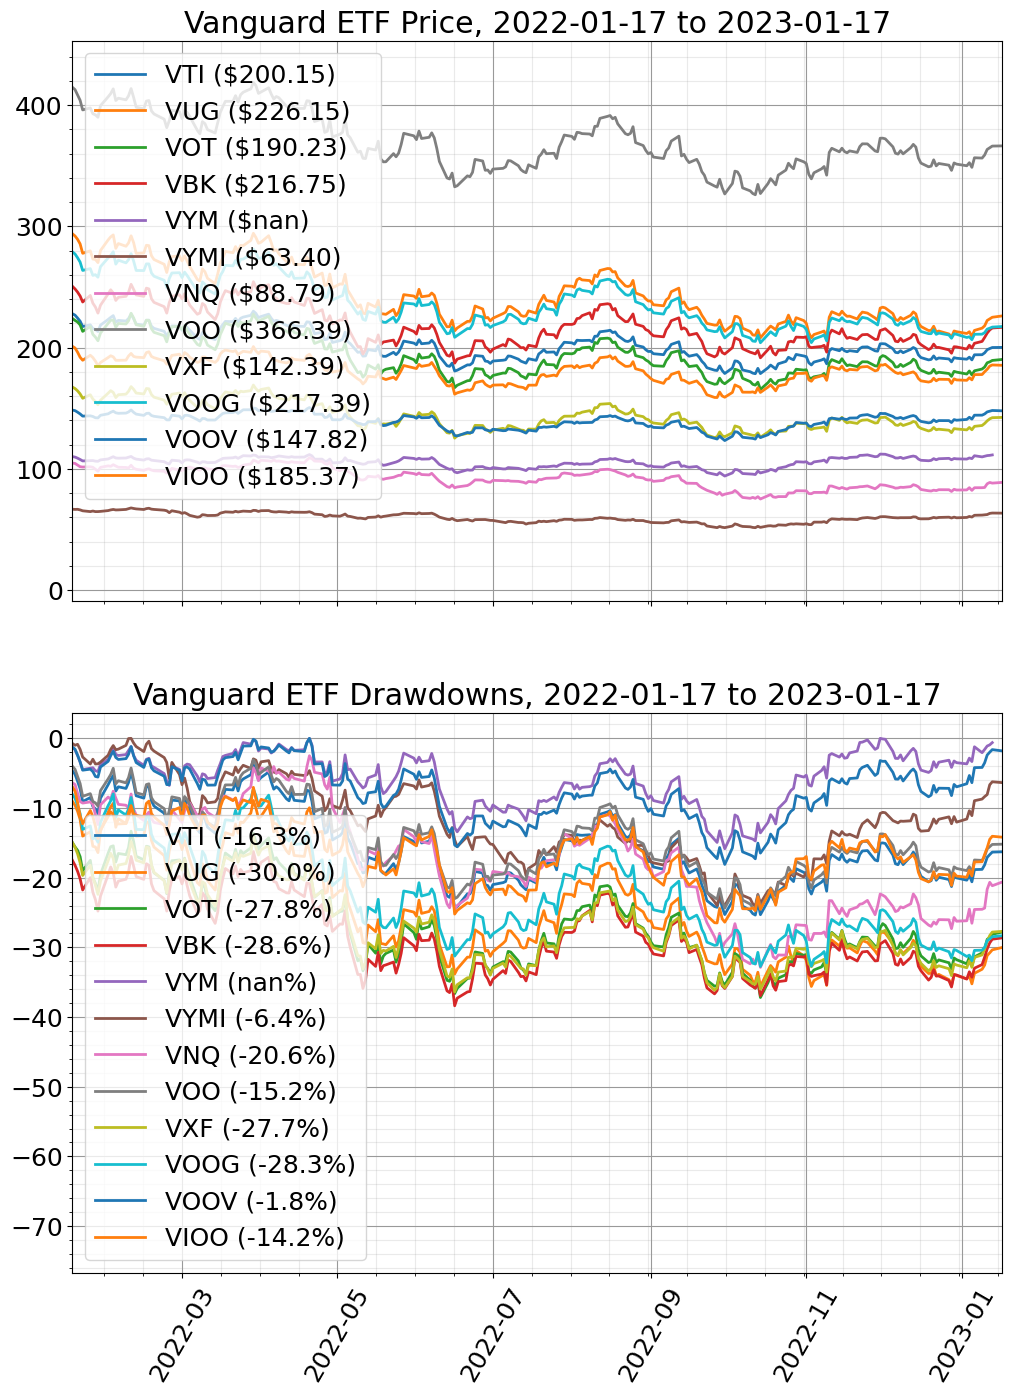

interactive(children=(SelectMultiple(description='Tickers', index=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11), opti…

In [3]:
# Compute the drawdown of an array, in place.
def drawdown (array):
    dd=deepcopy(array)
    maxval=-1
    for i in range(len(dd)):
        idx = i
        if array[idx] > maxval: maxval = array[idx]
        dd[idx] = (array[idx]/maxval - 1.) * 100.
    return dd

# Plot the prices & drawdowns over/under
def plot_vg_prices_dd(tickers, 
                      data,
                      logy,
                      date_min, 
                      date_max,
                      elapsed_days=-1):
        
    #print(data, len(data))
    print("vg_data_range={} to {}".format(data.index[0],
                                          data.index[-1]))

    if not date_max: date_max=datetime.date.today()
    if not date_min: date_min=date_max - datetime.timedelta(days=365)
    if elapsed_days > 1: date_min=date_max - datetime.timedelta(days=elapsed_days)
        
    tdelta = date_max - date_min
    print(date_min, date_max, tdelta)
    if tdelta > datetime.timedelta(days=50*365):
        print("requested time delta > 50 years, resetting")
        return

    fig, ax  = plt.subplots(nrows=2, ncols=1,
                            sharex=True, sharey=False,
                            figsize=(12,8*2))
    
    ax[0].set_title('Vanguard ETF Price, {} to {}'.format(date_min, date_max))
    ax[1].set_title('Vanguard ETF Drawdowns, {} to {}'.format(date_min, date_max))
    
    for t in tickers:
        #print(t, data[t].columns)
        #print(t, data[t])
        close = data['Close'][t]
        #print(type(close.index), type(close.values))
        dd = drawdown(close.values)

        ax[0].plot(close.index, close.values, label='{} (${:.2f})'.format(t,close.values[-1]), linewidth=2.0)
        ax[0].grid(visible=True, which='major', color='#999999', linestyle='-')
        ax[0].minorticks_on()
        ax[0].grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
        ax[0].legend(fancybox=True, loc=2)
        if logy: ax[0].set_yscale('log')

        ax[1].plot(close.index, dd, label='{} ({:.1f}%)'.format(t,dd[-1]), linewidth=2.0)
        ax[1].grid(visible=True, which='major', color='#999999', linestyle='-')
        ax[1].minorticks_on()
        ax[1].grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
        ax[1].legend(fancybox=True, loc=3)
        ax[1].set_xlim([date_min, date_max])
        plt.xticks(rotation=60)
    fig.savefig('vg_etf_shareprices.pdf', bbox_inches='tight')
    return

w = widgets.SelectMultiple(
    options=tickers,
    value=tickers,
    #rows=10,
    description='Tickers',
    disabled=False)


#plot_prices_dd(tickers, data)
p = interact(plot_vg_prices_dd,
             tickers=w, data=fixed(data),
             logy=False,
             date_min=widgets.DatePicker(description='Start Date', disabled=False),
             date_max=widgets.DatePicker(description='End Date', disabled=False),
             elapsed_days=widgets.IntSlider(min=-1, 
                                            max=min(15*365,len(data)), 
                                            step=1, value=-1,  
                                            continuous_update=False))
             

# Correlations
## Vanguard

In [4]:
import seaborn as sns
sns.set(style="white")

def vg_corr(num_days=None):
    # Set up the matplotlib figure
    fig, ax = plt.subplots(figsize=(10, 10))
    
    corr = ddata.iloc[-num_days:].corr() if num_days else ddata.corr()

    title = 'Vanguard ETF Correlations'
    if num_days: title += ' for Previous {} sessions'.format(num_days)
    
    ax.set_title(title)
    
    # Generate a mask for the upper triangle or diagonal
    #mask = np.triu(np.ones_like(corr, dtype=np.bool))
    mask = np.eye(len(corr))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, center=0, vmin=-1, vmax=1, cmap=cmap, annot=True,
                square=True, linewidths=.5, cbar_kws={"shrink": 0.5, "orientation": "horizontal"})

    ax.set_xlabel(None)
    ax.set_ylabel(None)
    #ax.set_yticklabels([ item.get_text().strip('Close-') for item in ax.get_yticklabels() ])
    ax.set_yticklabels(ax.get_yticklabels(),
                       rotation=0,
                       verticalalignment='center')
    ax.set_xticklabels(ax.get_yticklabels(),
                       rotation=45,
                       horizontalalignment='right')
    (bottom, top) = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    fig.savefig('vg_etf_correlation.pdf', bbox_inches='tight')
    return


#p = interact(vg_corr, 
#             num_days=widgets.IntSlider(min=10, 
#                                        max=min(5*365,len(ddata)), 
#                                        step=1, value=100, 
#                                        continuous_update=False))
p = interact(vg_corr, 
             num_days=widgets.IntText(value=100, description='# Days'))

ModuleNotFoundError: No module named 'seaborn'